In [59]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score

from itertools import combinations
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold, cross_val_score

# fetch dataset 
abalone = fetch_ucirepo(id=1) 

X = abalone.data.features 
y = abalone.data.targets 


In [60]:
X.shape, y.shape

((4177, 8), (4177, 1))

In [61]:
X.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


Length               Axes(0.125,0.798085;0.168478x0.0819149)
Diameter          Axes(0.327174,0.798085;0.168478x0.0819149)
Height            Axes(0.529348,0.798085;0.168478x0.0819149)
Whole_weight      Axes(0.731522,0.798085;0.168478x0.0819149)
Shucked_weight       Axes(0.125,0.699787;0.168478x0.0819149)
Viscera_weight    Axes(0.327174,0.699787;0.168478x0.0819149)
Shell_weight      Axes(0.529348,0.699787;0.168478x0.0819149)
dtype: object

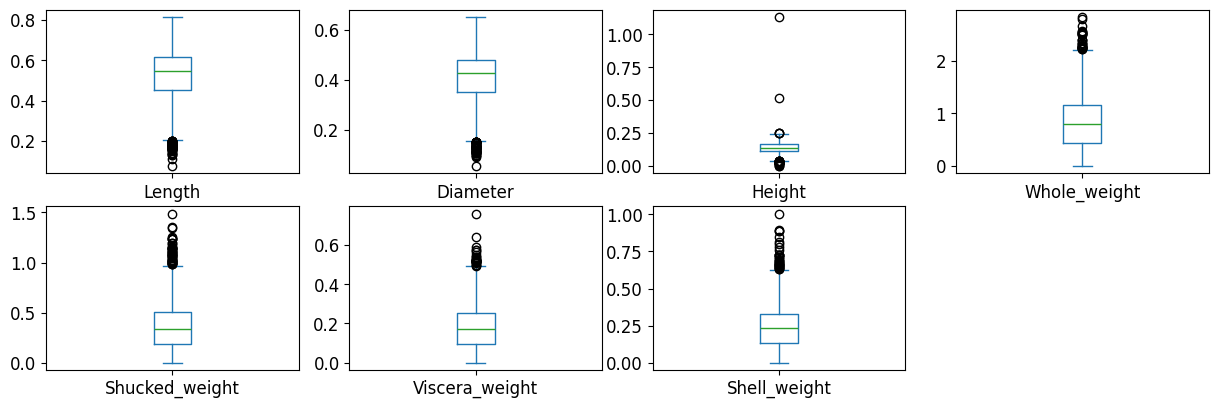

In [62]:
data_mean = X.iloc[:, :] 
data_mean.plot(kind='box', subplots=True, layout=(8,4), sharex=False,
sharey=False, fontsize=12, figsize=(15,20))

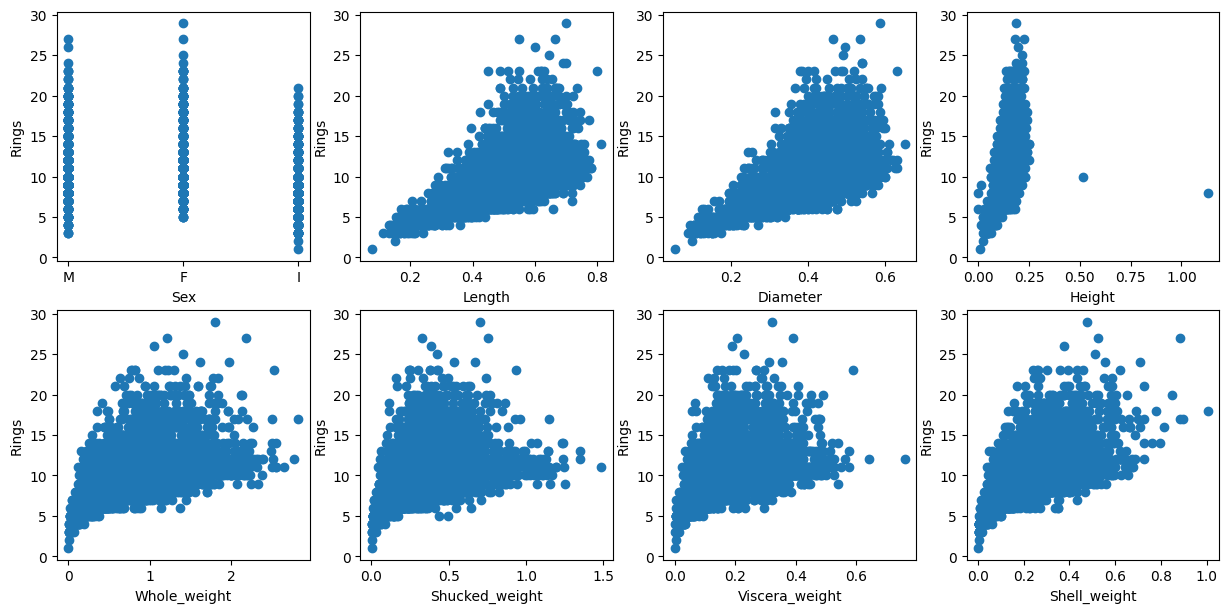

In [63]:
#plot each feature vs rings (column 8) in one figure
fig = plt.figure(figsize=(15, 11))
for i in range(data_mean.shape[1]):
    plt.subplot(3, 4, i+1)
    plt.scatter(data_mean.iloc[:, i], y)
    plt.xlabel(data_mean.columns[i])
    plt.ylabel('Rings')


In [64]:
outlier_indices = set()
for column in data_mean.columns:
  if not column.startswith("Sex"):
      
    Q1 = data_mean[column].quantile(0.25)
    Q3 = data_mean[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data_mean[(data_mean[column] < lower_bound) | (data_mean[column] > upper_bound)].index
    outlier_indices.update(outliers)

    outliers_sum = ((data_mean[column] < lower_bound) | (data_mean[column] > upper_bound)).sum()
    print(f'{column}: {outliers_sum} outliers')

outlier_indices = list(outlier_indices)

data_mean = data_mean.drop(index=outlier_indices).reset_index(drop=True)
y = y.drop(index=outlier_indices).reset_index(drop=True)

Length: 49 outliers
Diameter: 59 outliers
Height: 29 outliers
Whole_weight: 30 outliers
Shucked_weight: 48 outliers
Viscera_weight: 26 outliers
Shell_weight: 35 outliers


In [65]:
# Perform one-hot-encoding on sex feature
data_mean = pd.get_dummies(data_mean, columns=['Sex'])
data_mean.drop(columns=["Sex_I"], inplace=True) # Drop one dummy_variable to avoid multi collinearity

In [66]:
data_mean

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,True,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,False,False
...,...,...,...,...,...,...,...,...,...
4019,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,True,False
4020,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,False,True
4021,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,False,True
4022,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,True,False


<Axes: >

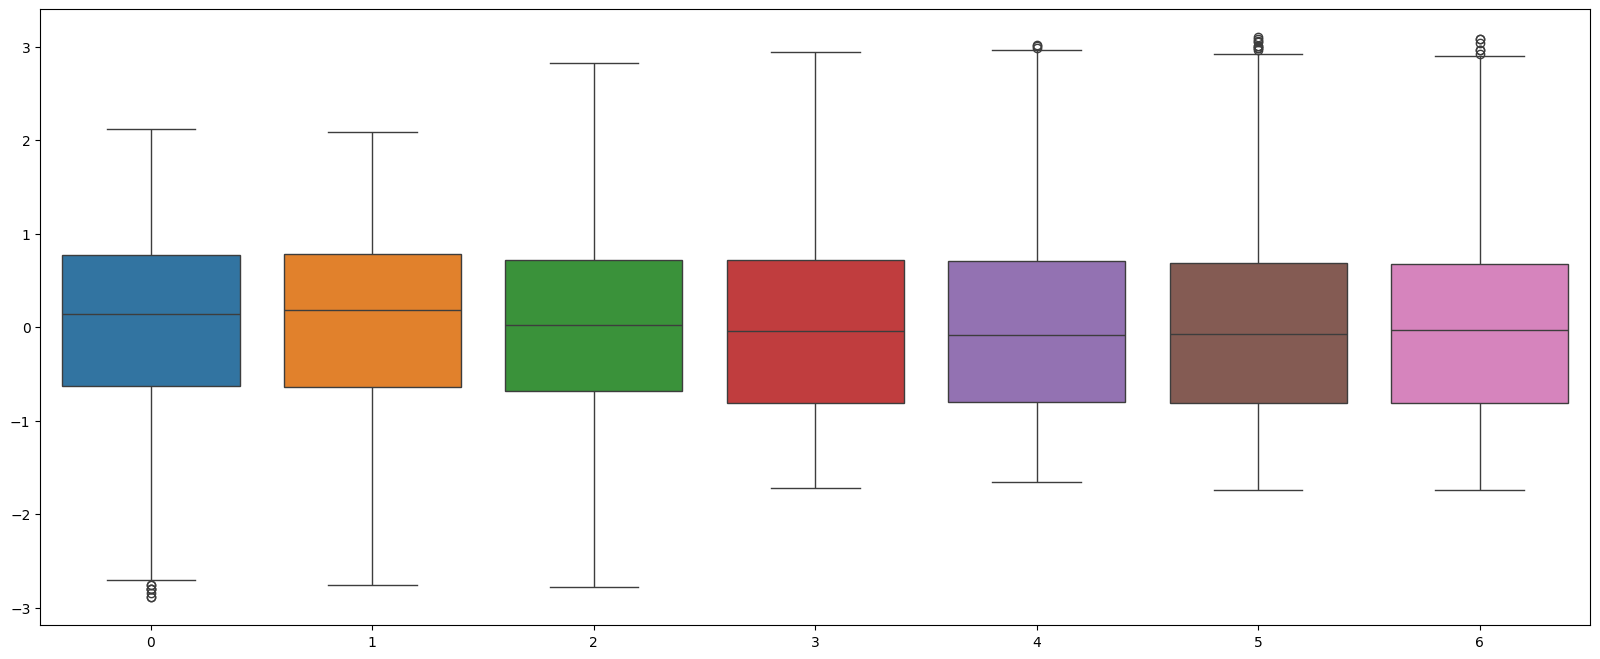

In [67]:
scaler = StandardScaler()
Xs = scaler.fit_transform(data_mean.iloc[:,:7]) # Ignore Sex dummy variables

# Print features normalised (Xs)
fig,ax=plt.subplots(1,figsize=(20,8))
sns.boxplot(data=Xs,ax=ax)

In [68]:
print(data_mean.shape)
print(y.shape)

(4024, 9)
(4024, 1)


### Linear Regression: No Kfold

In [69]:
## Linear regression

# Create linear regression object
lr = LinearRegression()

# Fit the model
lr.fit(data_mean, y)

# Print the coefficients
print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

# Predict the target values
y_pred = lr.predict(data_mean)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Coefficients: [[ -2.42997068   9.33712743  22.44194575   9.41125281 -20.83962867
  -12.22856335   9.76094157   0.7961611    0.84571875]]
Intercept: [3.29795528]
Mean Squared Error: 4.661114212932472
R^2 Score: 0.5220226341283686


### Linear Regression: With K-Fold Cross Validation (No hyperparameter tuning)

In [70]:
lr = LinearRegression()

# Define the k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = cross_val_score(lr, data_mean, y, scoring="neg_mean_squared_error", cv=kf)

scores*-1 # Turn MSEs to thei true positive values

# Print the cross-validation scores
print("Cross-validation MSE scores:", -scores)
print("Mean MSE:", -scores.mean())
print("Standard Deviation of MSE:", scores.std())

Cross-validation MSE scores: [4.4127614  5.24535705 4.44328541 5.00527586 4.39283089]
Mean MSE: 4.699902122027585
Standard Deviation of MSE: 0.35591259337647435


### Linear Regression: K-Fold Cross Validation with HyperParameter Tuning: Feature Selection

In [71]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Function to perform forward feature selection
def forward_feature_selection(X, y, kf):
    n_features = X.shape[1]
    best_features = []
    best_score = float('inf')

    for i in range(1, n_features + 1): # i = length of each possible combination
        feature_combinations = combinations(range(n_features), i) # All possible combinations of features with length i 
        for combination in feature_combinations:
            scores = []
            for train_index_ffs, val_index in kf.split(X): # Split into training and validation data
                X_train_ffs, X_val = X.iloc[train_index_ffs, list(combination)], X.iloc[val_index, list(combination)]
                y_train_ffs, y_val = y.iloc[train_index_ffs], y.iloc[val_index]

                model = LinearRegression()
                model.fit(X_train_ffs, y_train_ffs)
                y_pred_ffs = model.predict(X_val)
                scores.append(mean_squared_error(y_val, y_pred_ffs))

            avg_score = np.mean(scores)
            if avg_score < best_score:
                best_score = avg_score
                best_features = combination

    return best_features, best_score



# Perform k-fold cross-validation with forward feature selection
final_scores = []
best_feature_combinations = []

for train_index, test_index in kf.split(data_mean):
    X_train, X_test = data_mean.iloc[train_index], data_mean.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_features, _ = forward_feature_selection(X_train, y_train, KFold(n_splits=5, shuffle=True, random_state=1))
    best_feature_combinations.append(best_features)
    model = LinearRegression()

    model.fit(X_train.iloc[:, list(best_features)], y_train) # Fit model using best features
    y_pred = model.predict(X_test.iloc[:, list(best_features)]) # Get model predicted values
    final_scores.append(mean_squared_error(y_test, y_pred)) # Compare to test set 

    print(f"Completed fold with best features: {best_features}")

final_scores = np.array(final_scores)

# Print the MSEs
print("MSE for each fold:")
for i, scores in enumerate(final_scores):
    print(f"Fold {i+1}: {scores}")

print("Mean MSE:", final_scores.mean())

Completed fold with best features: (1, 2, 3, 4, 5, 6, 7, 8)
Completed fold with best features: (1, 2, 3, 4, 5, 6, 7, 8)
Completed fold with best features: (0, 1, 2, 3, 4, 5, 6, 7, 8)
Completed fold with best features: (1, 2, 3, 4, 5, 6, 7, 8)
Completed fold with best features: (1, 2, 3, 4, 5, 6, 7, 8)
MSE for each fold:
Fold 1: 4.413272857709245
Fold 2: 5.250540651958665
Fold 3: 4.443285411786729
Fold 4: 5.002951552118824
Fold 5: 4.397512777293124
Mean MSE: 4.701512650173317


### Linear Regression on resulting features from hyperparameter tuning: Feature Selection


In [72]:
selected_features = [1,2,3,4,5,6,7,8]

data_mean_selected = data_mean.iloc[:, selected_features]

lr = LinearRegression()

lr.fit(data_mean_selected, y)

print("Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)

y_pred = lr.predict(data_mean_selected)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Coefficients: [[  6.78870899  22.31222491   9.4104903  -20.94379775 -12.39676186
    9.80996704   0.80576053   0.85431709]]
Intercept: [3.13109293]
Mean Squared Error: 4.662989784853013
R^2 Score: 0.5218303022340769


### Linear Regression: K-Fold Cross Validation with HyperParameter Tuning: Polynomial Order

In [82]:
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1)

polynomial_range_num = 5 # Set hyperparameter range of values
kf_inner = KFold(n_splits=polynomial_range_num, shuffle=True, random_state=1) # Create kfold for inner loop

best_degree_list = []   # Best degrees resulting from inner fold
best_val_mse_list = []  # For inner fold
test_mse_list = [] # For outer fold

for train_index, test_index in kf.split(data_mean):
    X_train, X_test = data_mean.iloc[train_index], data_mean.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    best_degree = 1
    best_val_mse = np.inf

    degree = 1
    for train_index_inner, val_index in kf_inner.split(X_train):
        X_train_inner, X_val = X_train.iloc[train_index_inner],  X_train.iloc[val_index]
        y_train_inner, y_val = y_train.iloc[train_index_inner],  y_train.iloc[val_index]

        # train model with x_train_inner and y_train_inner with n polynomials
        poly_inner = PolynomialFeatures(degree, include_bias=False)

        # Create the pure and interaction terms of degree n
        X_train_inner_poly = poly_inner.fit_transform(X_train_inner)
        X_val_poly = poly_inner.transform(X_val)

        # Train model with polynomial terms
        model = LinearRegression()
        model.fit(X_train_inner_poly, y_train_inner)

        # validate model on validation data and get MSE
        y_pred_inner = model.predict(X_val_poly)
        mse = mean_squared_error(y_val, y_pred_inner)
        print(f"Degree {degree} Validation MSE: {mse:.4}", end=" ---- ")

        # if MSE is best so far, save degree and MSE
        if mse < best_val_mse:
            best_val_mse = mse
            best_degree = degree

        degree += 1
    
    best_degree_list.append(best_degree)
    best_val_mse_list.append(best_val_mse)

    poly = PolynomialFeatures(best_degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_test_pred = model.predict(X_test_poly)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mse_list.append(test_mse)
    print()


print()
print("Summary of outer folds:")
for i in range(num_splits):
    print(f"Fold {i+1}: Best Degree of {best_degree_list[i]}, Validation MSE = {best_val_mse_list[i]:.4f}, Test MSE = {test_mse_list[i]:.4f}")

Degree 1 Validation MSE: 5.06 ---- Degree 2 Validation MSE: 4.603 ---- Degree 3 Validation MSE: 5.15 ---- Degree 4 Validation MSE: 26.6 ---- Degree 5 Validation MSE: 4.679e+04 ---- 
Degree 1 Validation MSE: 4.413 ---- Degree 2 Validation MSE: 4.217 ---- Degree 3 Validation MSE: 7.279 ---- Degree 4 Validation MSE: 17.4 ---- Degree 5 Validation MSE: 1.694e+03 ---- 
Degree 1 Validation MSE: 5.007 ---- Degree 2 Validation MSE: 4.79 ---- Degree 3 Validation MSE: 5.682 ---- Degree 4 Validation MSE: 27.55 ---- Degree 5 Validation MSE: 1.571e+04 ---- 
Degree 1 Validation MSE: 4.162 ---- Degree 2 Validation MSE: 4.036 ---- Degree 3 Validation MSE: 6.929 ---- Degree 4 Validation MSE: 34.34 ---- Degree 5 Validation MSE: 1.892e+04 ---- 
Degree 1 Validation MSE: 4.823 ---- Degree 2 Validation MSE: 4.141 ---- Degree 3 Validation MSE: 4.839 ---- Degree 4 Validation MSE: 73.88 ---- Degree 5 Validation MSE: 3.064e+03 ---- 

Summary of outer folds:
Fold 1: Best Degree of 2, Validation MSE = 4.6033, Test